In [28]:
%load_ext autoreload
%autoreload 2

import xarray as xr

from discontinuum.providers import usgs
from discontinuum.utils import aggregate_to_daily

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# setup

# Illinois River, Valley City
site = "05586100"
start_date = "1980-01-01"
end_date = "2023-12-31"

characteristic = "Phosphorus"
# characteristic = 'Inorganic nitrogen (nitrate and nitrite)'

fraction = "Dissolved"
fraction = "Total"

In [30]:
# download data
filter_pcodes = []
filter_pcodes = [665]

daily = usgs.get_daily(site=site, start_date=start_date, end_date=end_date)
samples1 = usgs.get_samples(
    site=site,
    start_date=start_date,
    end_date=end_date,
    characteristic=characteristic,
    fraction=fraction,
    filter_pcodes=filter_pcodes,
)
samples2 = usgs.get_samples(
    site="05586300", start_date=start_date, end_date=end_date, characteristic=characteristic, fraction=fraction
)
samples3 = usgs.get_samples(
    site="IL_EPA_WQX-D-32",
    start_date=start_date,
    end_date=end_date,
    characteristic=characteristic,
    fraction=fraction,
    provider="STORET",
)

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, visit: https://doi-usgs.github.io/dataRetrieval/articles/Status.html. If you have additional questions about these changes, email CompTools@usgs.gov.
  warnings.warn(('USGS discrete water quality data availability '
/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, 

In [31]:
import numpy as np

if characteristic == "Phosphorus" and fraction == "Total":
    drop_index = samples2["concentration"].data.argmax()
    samples2["concentration"][drop_index] = np.nan
    samples2 = samples2.dropna(dim="time")

In [32]:
samples = xr.concat([samples1, samples2, samples3], dim="time").drop_duplicates(dim="time").sortby("time")

In [33]:
samples = aggregate_to_daily(samples)

training_data = xr.merge([samples, daily], join="inner")

In [37]:
training_data["flux"] = training_data["concentration"] * training_data["flow"] * 86400 * 1e-6  # kg/day
training_data["flux"].attrs = training_data["concentration"].attrs
training_data["flux"].attrs["units"] = "kg per day"

In [38]:
daily["flow"].mean()

<xarray.DataArray 'flow' ()> Size: 8B
array(745.44163651)

In [39]:
%%time
# fit model

from discontinuum.models import LoadestGP

model = LoadestGP()
model.fit(target=training_data["flux"], covariates=training_data[["time", "flow"]])

MAP ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2% 0:14:30 logp = -490.23, ||grad|| = 0.12713

CPU times: user 39.3 s, sys: 6.02 s, total: 45.3 s
Wall time: 25.2 s


<Axes: xlabel='time', ylabel='Phosphorus [kg per day]'>

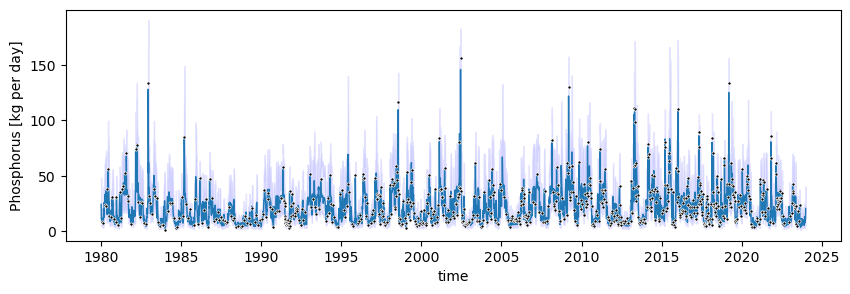

In [41]:
# plot result
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 3))
model.plot(daily[["time", "flow"]], ax=ax)

In [50]:
# get period 1
# counterfactual_period 1990-2021
# counterfactual_year = 1990
# p0 = daily[['time','flow']].sel(time=slice('1990','2021')) # full period
p0 = daily[["time", "flow"]].sel(time=slice("1980", "2023"))  # full period
# p1 = daily[['time','flow']].sel(time=slice('1990','1990')) #conditioning period; maybe too weird
p1 = daily[["time", "flow"]].sel(time=slice("2008", "2008"))  # conditioning period
q0 = p0["flow"].values
q1 = p1["flow"].values

# q2 = np.repeat(q, 2)
# q2.shape

import numpy as np

n0 = q0.shape[0]
n1 = q1.shape[0]
rep = np.ceil(n0 / n1)
q_temp = np.tile(q1, int(rep))
q1 = q_temp[:n0]  # counterfactual flow (repeating p1)
p2 = p0.copy()
p2["flow"].values = q1

In [53]:
Xcounter = model.dm.Xnew(p2)
Xoriginal = model.dm.Xnew(p0)

In [60]:
mu = {}
cov = {}
for k in ["trend", "seasonal", "covariates"]:
    mu[k], cov[k] = model.gp_kernels[k].predict(
        Xcounter,
        point=model.mp,
        diag=False,
        given={"gp": model.gp, "X": model.dm.X, "y": model.dm.y, "sigma": 0.01},
        model=model.model,
    )

k = "res"
mu[k], cov[k] = model.gp_kernels[k].predict(
    Xoriginal,
    point=model.mp,
    diag=False,
    pred_noise=True,
    given={"gp": model.gp, "X": model.dm.X, "y": model.dm.y, "sigma": 0.01},
    model=model.model,
)

In [61]:
rng = np.random.default_rng()
tol = 1e-6
n = 1000
method = "cholesky"
sim = 0.0

for k in mu.keys():
    print(k)
    sim += rng.multivariate_normal(mu[k], cov[k], size=n, method=method, tol=tol)

trend
seasonal
covariates
res


In [62]:
# sim.mean(axis=0)
model.dm.y_t(sim)

temp = model.dm.y_t(sim)
data = temp.data.reshape(n, -1)
attrs = temp.attrs
flux = xr.DataArray(
    data,
    coords={"time": p0.time, "draw": np.arange(n)},
    dims=["draw", "time"],
    attrs=attrs,
)

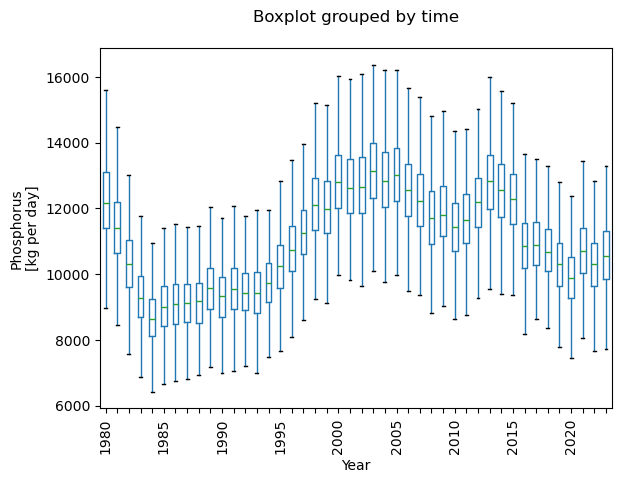

In [63]:
# compute load then do
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
annual_flux = flux.resample(time="YE").sum()

# plot
annual_flux.to_dataframe(name="load").boxplot(by="time", showfliers=False, grid=False, ax=ax)
ax.set_ylabel("{}\n[{}]".format(flux.attrs["long_name"], flux.attrs["units"]))
ax.set_xlabel("Year")
ax.tick_params(axis="x", labelrotation=90)

# label every 5th year
labels = ["" if (year % 5 != 0) else year for i, year in enumerate(annual_flux.time.dt.year.values)]
ax.set_xticklabels(labels)
ax.set_title("")

plt.show()

In [70]:
baseline = annual_flux.sel(time=slice("1980", "1996")).mean(dim="time")

In [76]:
# baseline.plot.hist()
# plt.show()
baseline.mean()

<xarray.DataArray ()> Size: 8B
array(9812.07029879)

In [75]:
last5 = annual_flux.sel(time=slice("2019", "2023")).mean(dim="time")
last5.mean()
# last5.plot.hist()
# plt.show()

<xarray.DataArray ()> Size: 8B
array(10379.95869975)

In [ ]:
#  plot
model.contourf(cmap="magma", levels=5)
plt.show()

In [10]:
sim = model.sample(daily[["time", "flow"]], pred_noise=True)

In [11]:
# sim = model.sample(daily[['time','flow']])

flux = sim * daily["flow"] * 86400 * 1e-6  # 1e-3 kg/day or 1e-6 t/day

<Axes: title={'center': 'load'}, xlabel='[time]'>

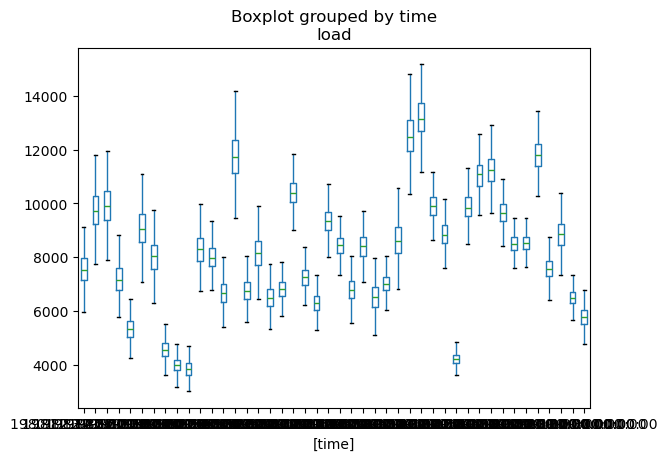

In [12]:
flux.resample(time="YE").sum().to_dataframe(name="load").boxplot(by="time", showfliers=False, grid=False)

<Axes: title={'center': 'load'}, xlabel='[time]'>

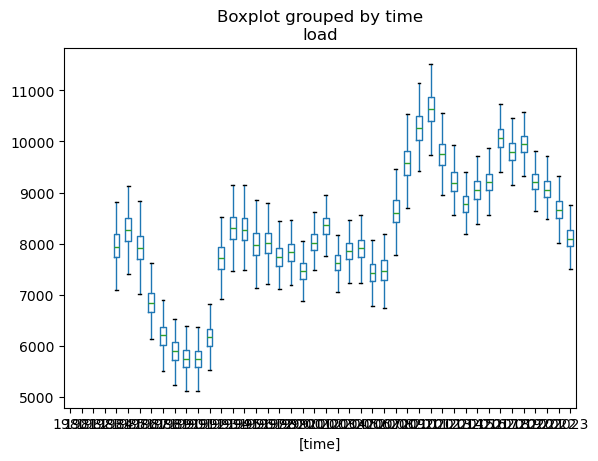

In [13]:
# rolling mean =
flux_5yr = flux.resample(time="YE").sum().rolling(time=5).mean()
flux_5yr["time"] = flux_5yr.time.dt.year
flux_5yr.to_dataframe(name="load").boxplot(by="time", showfliers=False, grid=False)

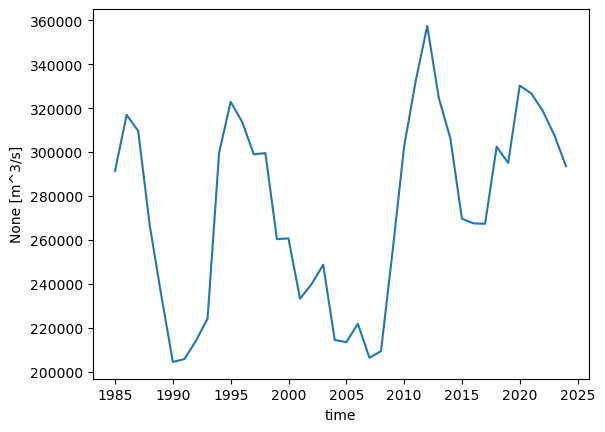

In [67]:
# rolling mean =
flow_5yr = daily["flow"].resample(time="YE").sum().rolling(time=5).mean()
flow_5yr.plot()  # .to_dataframe(name='load').boxplot(by='time', showfliers=False, grid=False)